In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Prio_n_step_Agent.Prio_DQN_Agent import Prio_DQN_Agent
from Prio_n_step_Agent.utils.random_agent import RandomAgent
from Prio_n_step_Agent.utils.actions import MORE_ACTIONS
import Prio_n_step_Agent.utils.stats_functions as sf
import hockey.hockey_env as h_env

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [3]:
reload(h_env)
env_name = "../weights/pure_prio_training_2_2_25"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5)
agent.Q.load(env_name, name= "episode_10000")

stats, losses = sf.load_stats(env_name)

/home/vaile/miniconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/vaile/miniconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Network loaded from ../weights/pure_prio_training_2_2_25/weights/episode_10000.pth


/home/vaile/Documents/Programming/hockey-en-mallorca/src/hockey-env/Prio_n_step_Agent/QFunction.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(tor

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/returns_plot.png


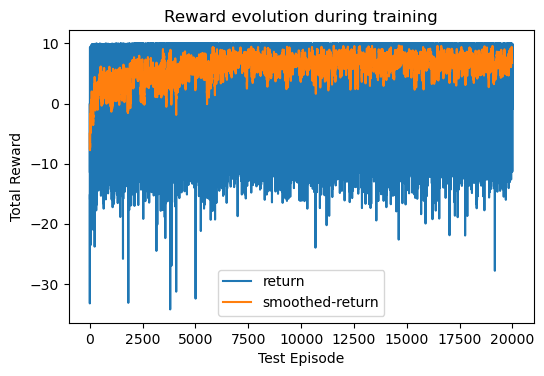

In [4]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/losses_plot.png


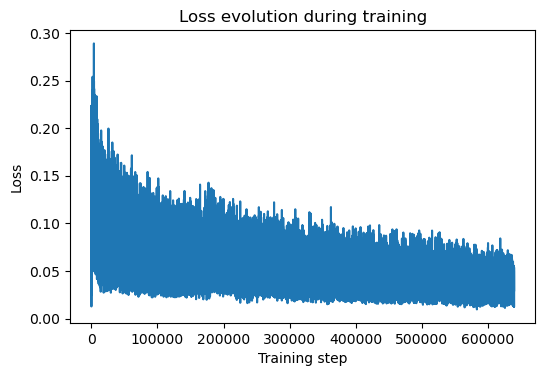

In [5]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/beta_evolution.png


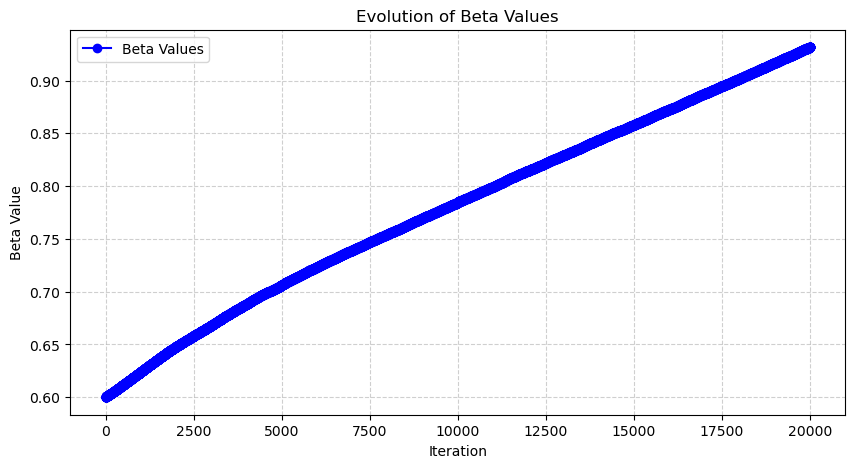

In [6]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/epsilon_evolution.png


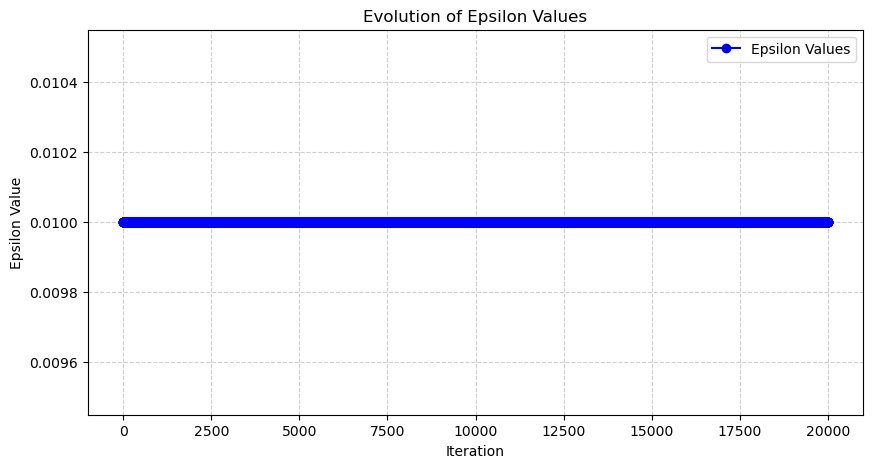

In [7]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/match_evolution.png


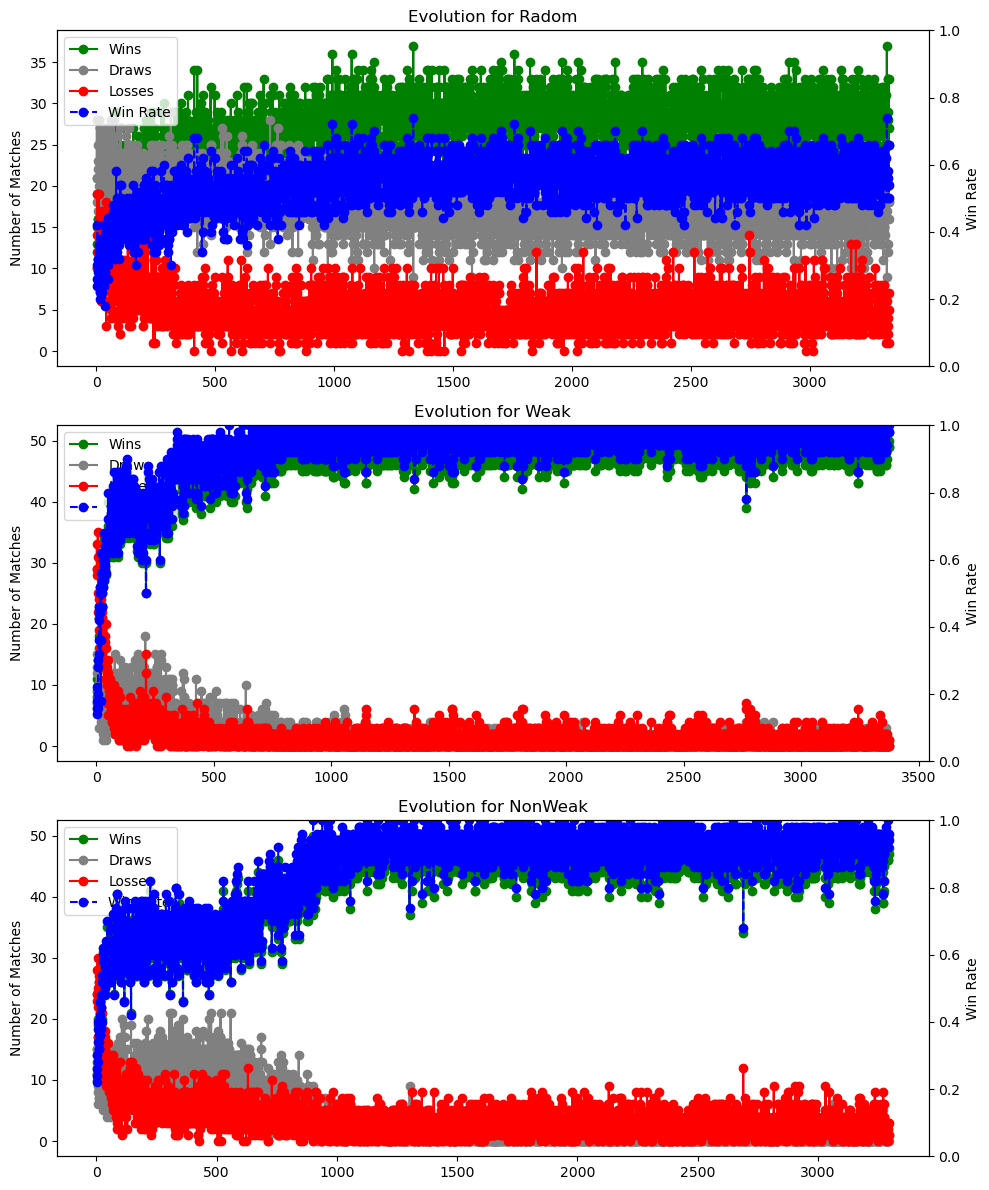

In [8]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history, ["Radom", "Weak", "NonWeak"], 50)

Test Episode 1, Total Reward: 0.0
Test Episode 2, Total Reward: 0.22878219640097086
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: -2.3311331376546764
Test Episode 5, Total Reward: 9.876918144247353
Test Episode 6, Total Reward: -26.580222162024945
Test Episode 7, Total Reward: 0.0
Test Episode 8, Total Reward: 9.494975350637837
Test Episode 9, Total Reward: -11.78675144724891
Test Episode 10, Total Reward: -5.345861858982397
Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/test_results_random.png


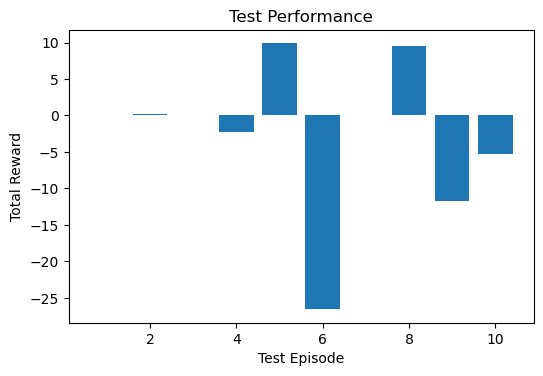

In [9]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = RandomAgent(seed)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/random", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/random/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_random")

Test Episode 1, Total Reward: 9.97199611994987
Test Episode 2, Total Reward: 9.595510076246992
Test Episode 3, Total Reward: -11.105837668775983
Test Episode 4, Total Reward: 9.31508937801926
Test Episode 5, Total Reward: -10.807407603508814
Test Episode 6, Total Reward: -38.11601533929765
Test Episode 7, Total Reward: 8.894294384286033
Test Episode 8, Total Reward: 9.361716673308008
Test Episode 9, Total Reward: 9.796139895061525
Test Episode 10, Total Reward: 9.24335661362688
Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/test_results_weak.png


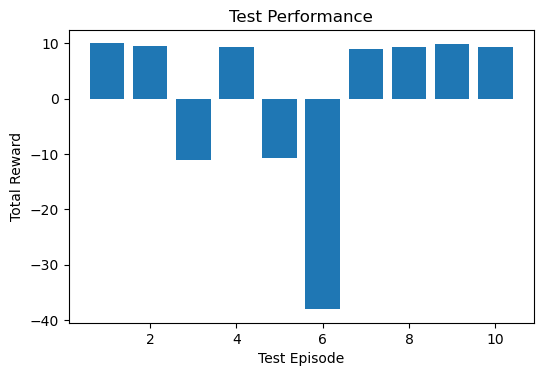

In [10]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent()

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/weak", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/weak/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_weak")

Test Episode 1, Total Reward: 2.749022552636287
Test Episode 2, Total Reward: 9.433321689801971
Test Episode 3, Total Reward: 7.957317058295129
Test Episode 4, Total Reward: 8.7508460704957
Test Episode 5, Total Reward: -10.681348580328818
Test Episode 6, Total Reward: -1.4918209943130876
Test Episode 7, Total Reward: 7.884501673656669
Test Episode 8, Total Reward: 9.416497696118622
Test Episode 9, Total Reward: 9.70911326192642
Test Episode 10, Total Reward: 9.466906869038906
Plot saved at ../weights/pure_prio_training_2_2_25/stats/plots/test_results_nonweak.png


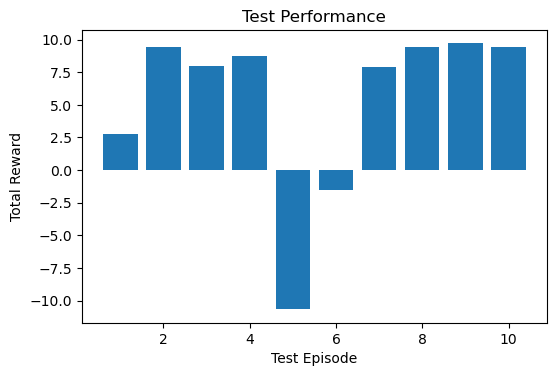

In [11]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent(weak=False)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/nonweak", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/nonweak/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_nonweak")

In [12]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")

TypeError: list indices must be integers or slices, not NoneType